# Bayesian Optimization
# Multi-Objective NAS with Ax

https://github.com/pytorch/botorch

# Defining the TorchX App

Our goal is to optimize the PyTorch Lightning training job defined in train.py. To do this using TorchX, we write a helper function that takes in the values of the architecture and hyperparameters of the training job and creates a TorchX AppDef with the appropriate settings.

In [1]:
from pathlib import Path

import torchx

from torchx import specs
from torchx.components import utils

In [2]:
def trainer(
    log_path: str,
    conv10_channels: int,
    conv20_channels: int,
    conv31_channels: int,
    conv32_channels: int,
    conv33_channels: int,
    conv34_channels: int,
    conv41_channels: int,
    conv42_channels: int,
    conv43_channels: int,
    conv44_channels: int,
    conv45_channels: int,
    last_channels: int,
    head_features: int,
    learning_rate: float,
    dropout: float,
    trial_idx: int = -1,
) -> specs.AppDef:

    # define the log path so we can pass it to the TorchX ``AppDef``
    if trial_idx >= 0:
        log_path = Path(log_path).joinpath(str(trial_idx)).absolute().as_posix()

    return utils.python(
        # command line arguments to the training script
        "--log_path",
        log_path,
        "--conv10_channels",
        str(conv10_channels),
        "--conv20_channels",
        str(conv20_channels),
        "--conv31_channels",
        str(conv31_channels),
        "--conv32_channels",
        str(conv32_channels),
        "--conv33_channels",
        str(conv33_channels),
        "--conv34_channels",
        str(conv34_channels),
        "--conv41_channels",
        str(conv41_channels),
         "--conv42_channels",
        str(conv42_channels),
        "--conv43_channels",
        str(conv43_channels),
        "--conv44_channels",
        str(conv44_channels),
        "--conv45_channels",
        str(conv45_channels),
        "--last_channels",
        str(last_channels),
        "--head_features",
        str(head_features),
        "--learning_rate",
        str(learning_rate),
        "--dropout",
        str(dropout),
        # other config options
        name="trainer",
        script="train.py",
        image=torchx.version.TORCHX_IMAGE,
    )

# Setting up the Runner
Ax’s Runner abstraction allows writing interfaces to various backends. Ax already comes with Runner for TorchX, and so we just need to configure it. For the purpose of this tutorial we run jobs locally in a fully asynchronous fashion.

In order to launch them on a cluster, you can instead specify a different TorchX scheduler and adjust the configuration appropriately. For example, if you have a Kubernetes cluster, you just need to change the scheduler from local_cwd to kubernetes).

In [3]:
import tempfile
from ax.runners.torchx import TorchXRunner

# Make a temporary dir to log our results into
log_dir = tempfile.mkdtemp()

ax_runner = TorchXRunner(
    tracker_base="/tmp/",
    component=trainer,
    # NOTE: To launch this job on a cluster instead of locally you can
    # specify a different scheduler and adjust arguments appropriately.
    scheduler="local_cwd",
    component_const_params={"log_path": log_dir},
    cfg={},
)

# Setting up the SearchSpace
First, we define our search space. Ax supports both range parameters of type integer and float as well as choice parameters which can have non-numerical types such as strings. We will tune the hidden sizes, learning rate, dropout, and number of epochs as range parameters and tune the batch size as an ordered choice parameter to enforce it to be a power of 2.

In [4]:
from ax.core import (
    ChoiceParameter,
    ParameterType,
    RangeParameter,
    SearchSpace,
    OrderConstraint,
)

parameters = [
    # NOTE: In a real-world setting, hidden_size_1 and hidden_size_2
    # should probably be powers of 2, but in our simple example this
    # would mean that ``num_params`` can't take on that many values, which
    # in turn makes the Pareto frontier look pretty weird.
    ChoiceParameter(  # NOTE: ``ChoiceParameters`` don't require log-scale
        name="conv10_channels",
        values=[32, 64],
        parameter_type=ParameterType.INT,
        is_ordered=True,
        sort_values=True,
    ),
    ChoiceParameter(  # NOTE: ``ChoiceParameters`` don't require log-scale
        name="conv20_channels",
        values=[16, 24, 32],
        parameter_type=ParameterType.INT,
        is_ordered=True,
        sort_values=True,
    ),
    ChoiceParameter(  # NOTE: ``ChoiceParameters`` don't require log-scale
        name="conv31_channels",
        values=[4, 8, 16],
        parameter_type=ParameterType.INT,
        is_ordered=True,
        sort_values=True,
    ),
    ChoiceParameter(  # NOTE: ``ChoiceParameters`` don't require log-scale
        name="conv32_channels",
        values=[16, 32, 64],
        parameter_type=ParameterType.INT,
        is_ordered=True,
        sort_values=True,
    ),
    ChoiceParameter(  # NOTE: ``ChoiceParameters`` don't require log-scale
        name="conv33_channels",
        values=[16, 32, 64],
        parameter_type=ParameterType.INT,
        is_ordered=True,
        sort_values=True,
    ),
    ChoiceParameter(  # NOTE: ``ChoiceParameters`` don't require log-scale
        name="conv34_channels",
        values=[32, 64, 128],
        parameter_type=ParameterType.INT,
        is_ordered=True,
        sort_values=True,
    ),
    ChoiceParameter(  # NOTE: ``ChoiceParameters`` don't require log-scale
        name="conv41_channels",
        values=[8, 16, 32, 64],
        parameter_type=ParameterType.INT,
        is_ordered=True,
        sort_values=True,
    ),
    ChoiceParameter(  # NOTE: ``ChoiceParameters`` don't require log-scale
        name="conv42_channels",
        values=[32, 64, 128],
        parameter_type=ParameterType.INT,
        is_ordered=True,
        sort_values=True,
    ),
    ChoiceParameter(  # NOTE: ``ChoiceParameters`` don't require log-scale
        name="conv43_channels",
        values=[8, 16, 32, 64],
        parameter_type=ParameterType.INT,
        is_ordered=True,
        sort_values=True,
    ),
    ChoiceParameter(  # NOTE: ``ChoiceParameters`` don't require log-scale
        name="conv44_channels",
        values=[32, 64, 128, 256],
        parameter_type=ParameterType.INT,
        is_ordered=True,
        sort_values=True,
    ),
    ChoiceParameter(  # NOTE: ``ChoiceParameters`` don't require log-scale
        name="conv45_channels",
        values=[16, 32, 64, 128],
        parameter_type=ParameterType.INT,
        is_ordered=True,
        sort_values=True,
    ),
    ChoiceParameter(  # NOTE: ``ChoiceParameters`` don't require log-scale
        name="last_channels",
        values=[32, 64, 128, 256],
        parameter_type=ParameterType.INT,
        is_ordered=True,
        sort_values=True,
    ),
    ChoiceParameter(  # NOTE: ``ChoiceParameters`` don't require log-scale
        name="head_features",
        values=[4, 8, 16, 32],
        parameter_type=ParameterType.INT,
        is_ordered=True,
        sort_values=True,
    ),
    RangeParameter(
        name="learning_rate",
        lower=1e-4,
        upper=1e-2,
        parameter_type=ParameterType.FLOAT,
        log_scale=True,
    ),
    RangeParameter(
        name="dropout",
        lower=0.0,
        upper=0.5,
        parameter_type=ParameterType.FLOAT,
    ),
]

#con_1 = OrderConstraint(lower_parameter=parameters[idx], upper_parameter=parameters[idx])


search_space = SearchSpace(
    parameters=parameters,
    # NOTE: In practice, it may make sense to add a constraint
    # hidden_size_2 <= hidden_size_1
    #parameter_constraints=[],
)

# Setting up Metrics
Ax has the concept of a Metric that defines properties of outcomes and how observations are obtained for these outcomes. This allows e.g. encoding how data is fetched from some distributed execution backend and post-processed before being passed as input to Ax.

In this tutorial we will use multi-objective optimization with the goal of maximizing the validation mean F1 Score and minimizing the number of model parameters. The latter represents a simple proxy of model latency, which is hard to estimate accurately for small ML models (in an actual application we would benchmark the latency while running the model on-device).

In our example TorchX will run the training jobs in a fully asynchronous fashion locally and write the results to the log_dir based on the trial index (see the trainer() function above). We will define a metric class that is aware of that logging directory. By subclassing TensorboardCurveMetric we get the logic to read and parse the TensorBoard logs for free.

In [5]:
from ax.metrics.tensorboard import TensorboardCurveMetric


class MyTensorboardMetric(TensorboardCurveMetric):

    # NOTE: We need to tell the new TensorBoard metric how to get the id /
    # file handle for the TensorBoard logs from a trial. In this case
    # our convention is to just save a separate file per trial in
    # the prespecified log dir.
    @classmethod
    def get_ids_from_trials(cls, trials):
        return {
            trial.index: Path(log_dir).joinpath(str(trial.index)).as_posix()
            for trial in trials
        }

    # This indicates whether the metric is queryable while the trial is
    # still running. We don't use this in the current tutorial, but Ax
    # utilizes this to implement trial-level early-stopping functionality.
    @classmethod
    def is_available_while_running(cls):
        return False

Now we can instantiate the metrics for F1 Score and the number of model parameters. Here curve_name is the name of the metric in the TensorBoard logs, while name is the metric name used internally by Ax. We also specify lower_is_better to indicate the favorable direction of the two metrics.

In [6]:
val_mean_f1 = MyTensorboardMetric(
    name="val_mean_f1",
    curve_name="val_mean_f1",
    lower_is_better=False,
)
model_num_params = MyTensorboardMetric(
    name="num_params",
    curve_name="num_params",
    lower_is_better=True,
)

# Setting up the OptimizationConfig
The way to tell Ax what it should optimize is by means of an OptimizationConfig. Here we use a MultiObjectiveOptimizationConfig as we will be performing multi-objective optimization.

Additionally, Ax supports placing constraints on the different metrics by specifying objective thresholds, which bound the region of interest in the outcome space that we want to explore. For this example, we will constrain the validation F1 Score to be at least 0.90 (90%) and the number of model parameters to be at most 200,000.

In [7]:
from ax.core import MultiObjective, Objective, ObjectiveThreshold
from ax.core.optimization_config import MultiObjectiveOptimizationConfig


opt_config = MultiObjectiveOptimizationConfig(
    objective=MultiObjective(
        objectives=[
            Objective(metric=val_mean_f1, minimize=False),
            Objective(metric=model_num_params, minimize=True),
        ],
    ),
    objective_thresholds=[
        ObjectiveThreshold(metric=val_mean_f1, bound=0.90, relative=False),
        ObjectiveThreshold(metric=model_num_params, bound=90_000, relative=False),
    ],
)

# Creating the Ax Experiment
In Ax, the Experiment object is the object that stores all the information about the problem setup.

In [8]:
from ax.core import Experiment

experiment = Experiment(
    name="torchx_bed",
    search_space=search_space,
    optimization_config=opt_config,
    runner=ax_runner,
)

# Choosing the Generation Strategy
A GenerationStrategy is the abstract representation of how we would like to perform the optimization. While this can be customized (if you’d like to do so, see this tutorial), in most cases Ax can automatically determine an appropriate strategy based on the search space, optimization config, and the total number of trials we want to run.

Typically, Ax chooses to evaluate a number of random configurations before starting a model-based Bayesian Optimization strategy.

In [9]:
total_trials = 4  # total evaluation budget

from ax.modelbridge.dispatch_utils import choose_generation_strategy

gs = choose_generation_strategy(
    search_space=experiment.search_space,
    optimization_config=experiment.optimization_config,
    num_trials=total_trials,
  )

[INFO 06-12 07:26:45] ax.modelbridge.dispatch_utils: Using Models.BOTORCH_MODULAR since there is at least one ordered parameter and there are no unordered categorical parameters.
[INFO 06-12 07:26:45] ax.modelbridge.dispatch_utils: Calculating the number of remaining initialization trials based on num_initialization_trials=None max_initialization_trials=None num_tunable_parameters=15 num_trials=4 use_batch_trials=False
[INFO 06-12 07:26:45] ax.modelbridge.dispatch_utils: calculated num_initialization_trials=5
[INFO 06-12 07:26:45] ax.modelbridge.dispatch_utils: num_completed_initialization_trials=0 num_remaining_initialization_trials=5
[INFO 06-12 07:26:45] ax.modelbridge.dispatch_utils: `verbose`, `disable_progbar`, and `jit_compile` are not yet supported when using `choose_generation_strategy` with ModularBoTorchModel, dropping these arguments.
[INFO 06-12 07:26:45] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+BoTorch'

# Configuring the Scheduler
The Scheduler acts as the loop control for the optimization. It communicates with the backend to launch trials, check their status, and retrieve results. In the case of this tutorial, it is simply reading and parsing the locally saved logs. In a remote execution setting, it would call APIs. 

The Scheduler requires the Experiment and the GenerationStrategy. A set of options can be passed in via SchedulerOptions. Here, we configure the number of total evaluations as well as max_pending_trials, the maximum number of trials that should run concurrently. In our local setting, this is the number of training jobs running as individual processes, while in a remote execution setting, this would be the number of machines you want to use in parallel.

In [10]:
from ax.service.scheduler import Scheduler, SchedulerOptions

scheduler = Scheduler(
    experiment=experiment,
    generation_strategy=gs,
    options=SchedulerOptions(
        total_trials=total_trials, max_pending_trials=2
    ),
)

[INFO 06-12 07:26:45] Scheduler: `Scheduler` requires experiment to have immutable search space and optimization config. Setting property immutable_search_space_and_opt_config to `True` on experiment.


# Running the optimization
Now that everything is configured, we can let Ax run the optimization in a fully automated fashion. The Scheduler will periodically check the logs for the status of all currently running trials, and if a trial completes the scheduler will update its status on the experiment and fetch the observations needed for the Bayesian optimization algorithm.

In [11]:
scheduler.run_all_trials()

[INFO 06-12 07:26:45] Scheduler: Fetching data for newly completed trials: [].
[INFO 06-12 07:26:45] Scheduler: Running trials [0]...
[INFO 06-12 07:26:46] Scheduler: Running trials [1]...
[INFO 06-12 07:26:47] Scheduler: Fetching data for newly completed trials: [].
[INFO 06-12 07:26:47] Scheduler: Waiting for completed trials (for 1 sec, currently running trials: 2).
[INFO 06-12 07:26:48] Scheduler: Fetching data for newly completed trials: [].
[INFO 06-12 07:26:48] Scheduler: Waiting for completed trials (for 1.5 sec, currently running trials: 2).
[INFO 06-12 07:26:50] Scheduler: Fetching data for newly completed trials: [].
[INFO 06-12 07:26:50] Scheduler: Waiting for completed trials (for 2 sec, currently running trials: 2).
[INFO 06-12 07:26:52] Scheduler: Fetching data for newly completed trials: [].
[INFO 06-12 07:26:52] Scheduler: Waiting for completed trials (for 3 sec, currently running trials: 2).
[INFO 06-12 07:26:55] Scheduler: Fetching data for newly completed trials: []

OptimizationResult()

# Evaluating the results
We can now inspect the result of the optimization using helper functions and visualizations included with Ax.

First, we generate a dataframe with a summary of the results of the experiment. Each row in this dataframe corresponds to a trial (that is, a training job that was run), and contains information on the status of the trial, the parameter configuration that was evaluated, and the metric values that were observed. This provides an easy way to sanity check the optimization.

In [15]:
from ax.service.utils.report_utils import exp_to_df

df = exp_to_df(experiment)
df.head(4)

/opt/conda/envs/pytorch_light/lib/python3.10/site-packages/ax/core/map_data.py:190: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[WARNING 06-12 09:59:51] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


,trial_index,arm_name,trial_status,generation_method,is_feasible,num_params,val_mean_f1,conv10_channels,conv20_channels,conv31_channels,...,conv34_channels,conv41_channels,conv42_channels,conv43_channels,conv44_channels,conv45_channels,last_channels,head_features,learning_rate,dropout
0,0,0_0,COMPLETED,Sobol,False,449154.0,0.880747,32,16,16,...,128,8,128,32,256,128,256,8,0.000199,0.051839
1,1,1_0,COMPLETED,Sobol,False,219858.0,0.855376,64,16,8,...,64,16,32,64,256,16,256,4,0.000807,0.442896
2,2,2_0,COMPLETED,Sobol,False,232930.0,0.899544,64,32,8,...,64,32,128,64,128,64,64,8,0.001029,0.486576
3,3,3_0,COMPLETED,Sobol,False,375410.0,0.905497,32,32,16,...,128,32,128,64,256,64,128,4,0.001297,0.352927


We can also visualize the Pareto frontier of tradeoffs between the validation accuracy and the number of model parameters.

Ax uses Plotly to produce interactive plots, which allow you to do things like zoom, crop, or hover in order to view details of components of the plot. Try it out, and take a look at the visualization tutorial if you’d like to learn more).

The final optimization results are shown in the figure below where the color corresponds to the iteration number for each trial. We see that our method was able to successfully explore the trade-offs and found both large models with high validation accuracy as well as small models with comparatively lower validation accuracy.

/opt/conda/envs/pytorch_light/lib/python3.10/site-packages/ax/core/map_data.py:190: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[WARNING 06-12 09:59:52] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


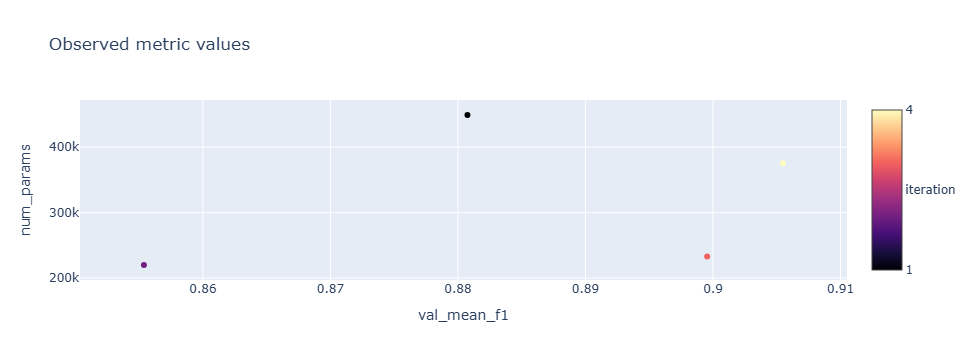

In [16]:
from ax.service.utils.report_utils import _pareto_frontier_scatter_2d_plotly

_pareto_frontier_scatter_2d_plotly(experiment)

To better understand what our surrogate models have learned about the black box objectives, we can take a look at the leave-one-out cross validation results. Since our models are Gaussian Processes, they not only provide point predictions but also uncertainty estimates about these predictions. A good model means that the predicted means (the points in the figure) are close to the 45 degree line and that the confidence intervals cover the 45 degree line with the expected frequency (here we use 95% confidence intervals, so we would expect them to contain the true observation 95% of the time).

As the figures below show, the model size (num_params) metric is much easier to model than the validation F1 Score (f1 mean) metric.

In [17]:
from ax.modelbridge.cross_validation import compute_diagnostics, cross_validate
from ax.plot.diagnostic import interact_cross_validation_plotly
from ax.utils.notebook.plotting import init_notebook_plotting, render

cv = cross_validate(model=gs.model)  # The surrogate model is stored on the ``GenerationStrategy``
compute_diagnostics(cv)

interact_cross_validation_plotly(cv)

NotImplementedError: 

We can also make contour plots to better understand how the different objectives depend on two of the input parameters. In the figure below, we show the validation accuracy predicted by the model as a function of the two hidden sizes. The validation accuracy clearly increases as the hidden sizes increase.

In [18]:
from ax.plot.contour import interact_contour_plotly

interact_contour_plotly(model=gs.model, metric_name="val_mean_f1")

NotImplementedError: RandomModelBridge does not support prediction.

Similarly, we show the number of model parameters as a function of the conv sizes in the figure below and see that it also increases as a function of the hidden sizes (the dependency on hidden_size_1 is much larger).

In [ ]:
interact_contour_plotly(model=gs.model, metric_name="num_params")

# Save to excel

In [20]:
df.to_excel("bop_nas_90k.xlsx")
df.to_csv("bop_nas_90k.csv")